# [Feature Engineering](https://www.kaggle.com/code/ryanholbrook/what-is-feature-engineering)

By learn feature engineering, You'll know how to:

* determine which features are the most important with mutual information
* invent new features in several real-world problem domains
* encode high-cardinality categoricals with a target encoding
* create segmentation features with k-means clustering
* decompose a dataset's variation into features with principal component analysis

Benefits of feature engineering
* improve predictive performance
* reduce computational or data needs
* improve interpretability of the results

## A Guiding Principle of Feature Engineering

**Principle**
> Choose features that have relationship with target.

e.g. in linear models, choose or transform the features to make them have linear relationship to the target.

In house price predict linear model, we choose area=length * width as a squared feature. The linear model fits better than using length or width in this case.

### Example - Concrete Formulations

Given a task to predict a concrete's compressive strength from its formulation.

We can improve the predictive performance of a [<u>random forest model</u>](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) by adding a few synthetic features.



In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("data/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


#### Create baseline

Establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

By run the code below, we get an base line score: 8.232.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(
    criterion="absolute_error",   # measure the quality of a tree split. default=”squared_error”
    random_state=0                # Controls the randomnes of sampling
)

baseline_score = cross_val_score(
    baseline,   # estimator: model to fit test data
    X,          # features
    y,          # target
    cv=5,       # set cross-validation splitting strategy. KFold=5
    scoring="neg_mean_absolute_error",
)

baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


API reference:
* [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

#### Improve predictive performance

Since the ratio of ingredients usually is a better predictor than their absolute amounts. We create ratios of the features for CompressiveStrength prediction this time.

In [4]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(
    criterion="absolute_error", 
    random_state=0
)

score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


The MAE score 7.948 < baseline 8.232. 

This is evidence that these new ratios exposed important information to the model that it wasn't detecting before.

## [Mutual Information (MI)](https://www.kaggle.com/code/ryanholbrook/mutual-information)
**Mutual Information (MI)** is a measure of the mutual dependence between **two random variables(a pair)** in terms of the information they provide about each other. In other words, it quantifies how much knowing one variable reduces uncertainty about the other.

Things to know when applying mutual information in feature selection:
* A variable with high mutual information with the target are often considered more relevant for modeling tasks, as it provides more predictive power.
* It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a `univariate` metric. 
  * MI measures pairwise relationships: MI calculates the amount of information shared between pairs of variables. It does not directly consider interactions among multiple variables simultaneously. Therefore, it might not capture higher-order relationships or interactions involving more than two variables.
  * Nonlinear relationships: MI, in its basic form, measures linear relationships between variables. If the interactions between features are nonlinear, MI might not be able to capture them accurately.
* The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

### Example - 1985 Automobiles

The task is predict the price (the target) of a car from features, such as `make`, `body_style`, `horsepower`, etc. 

In this example, we'll rank the features with mutual information and investigate the results by data visualization.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

df = pd.read_csv("data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats `discrete` features differently from `continuous` features. 
* Float type variable is a continues feature, except
  * it has been divided into bins or categories and each float value corresponds to a specific bin or category.
* Categoricals (object or categorial dtype) can be treated as discrete by label encoding.

In [9]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

display(X.head())
display(discrete_features.head())

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
1,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
2,1,0,0,0,2,1,0,0,94.5,171.2,...,6,152,0,2.68,3.47,9,154,5000,19,26
3,2,1,0,0,4,2,1,0,99.8,176.6,...,4,109,0,3.19,3.40,10,102,5500,24,30
4,2,1,0,0,4,2,2,0,99.4,176.6,...,5,136,0,3.19,3.40,8,115,5500,18,22


symboling       True
make            True
fuel_type       True
aspiration      True
num_of_doors    True
dtype: bool

Scikit-learn has two <u>mutual information metrics</u> in its `feature_selection module`: 
1. **real-valued** targets (`mutual_info_regression`)
2. **categorical** targets (`mutual_info_classif`)

Target `price` is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [15]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    # Compute MI with mutual_info_regression() method
    mi_scores = mutual_info_regression(
        X,   # Feature dataframe.
        y,   # Target series
        discrete_features=discrete_features #
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

# show a few features with their MI scores (show 1 from every 3 rows)
mi_scores[::3]  

curb_weight          1.413759
highway_mpg          0.952835
length               0.619486
bore                 0.488112
stroke               0.385982
num_of_cylinders     0.331096
compression_ratio    0.133115
fuel_type            0.047279
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

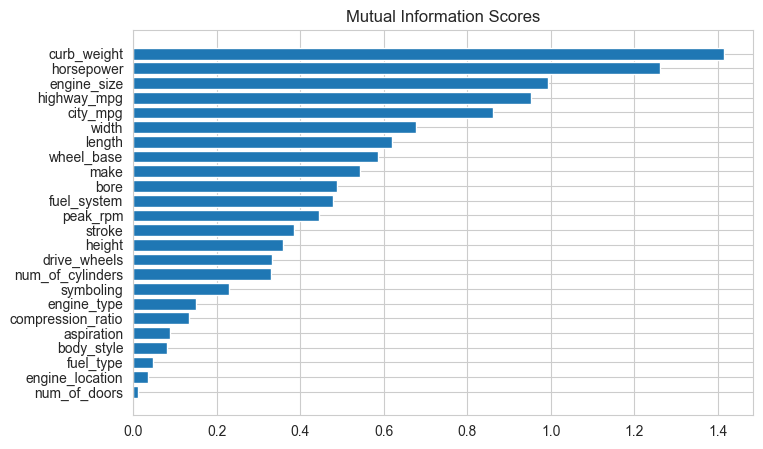

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with the target `price`.

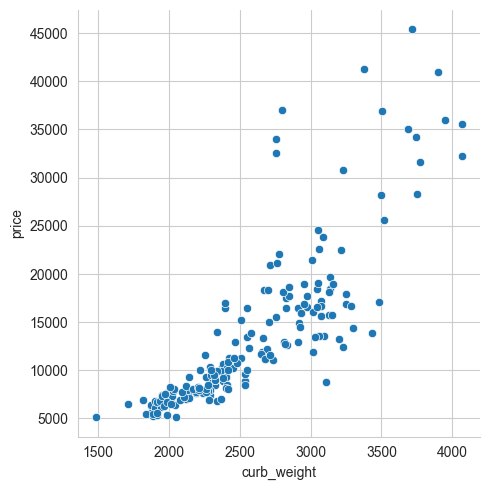

In [17]:
sns.relplot(
    data=df, 
    x="curb_weight", 
    y="price",
    kind='scatter',   # the defaul and the same as sns.scatterplot()
);

The `fuel_type` feature has a fairly low MI score. Let's add 'fuel_type' category to see the plot. 

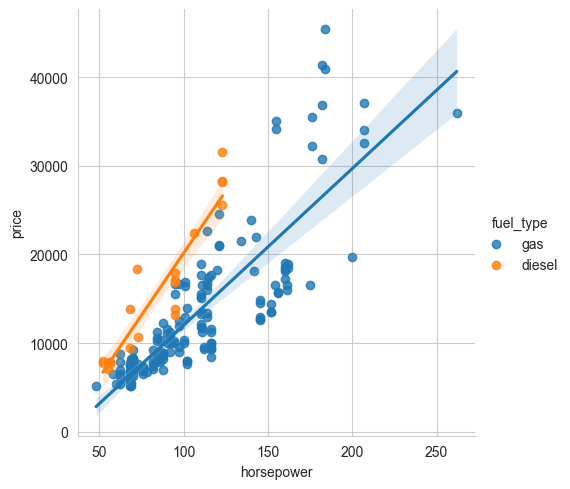

In [18]:
sns.lmplot(
    data=df, 
    x="horsepower", 
    y="price", 
    hue="fuel_type"  # colored categorical on fuel_type column
);

The `fuel_type` clearly separates two price populations with different trends within the horsepower feature. It indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. 

Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance.

## Transform features